# benchmarking on sergio


In [1]:
from bengrn import BenGRN

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import read_h5ad


from scdataloader import utils as data_utils

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

→ connected lamindb: jkobject/scprint


In [2]:
import sys

sys.path.insert(0, "../")
from scgpt_helper import prepare_model, generate_grn
from scgpt.utils import set_seed
set_seed(42)

/home/ml4ig1/Documents code/scGPT/mytests/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/ml4ig1/Documents code/scGPT/mytests/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [3]:
model, vocab = prepare_model(model_dir="../save/scGPT_human")

Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.


/home/ml4ig1/Documents code/scGPT/mytests/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


In [5]:
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

genes = torch.load('../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

In [6]:
adata = read_h5ad("../../scPRINT/tools/SERGIO/sergio_gt_grn.h5ad")
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
genesdf = data_utils.load_genes(adata.obs.organism_ontology_term_id.iloc[0])
adata

GRnnData object with n_obs × n_vars = 1000 × 813
    obs: 'organism_ontology_term_id'
    varp: 'GRN'
    with a grn of 3546 elements

In [7]:
# Merge adata.var with genesdf
# First, ensure the index of adata.var is named
adata.var.index.name = 'symbol'

# Merge adata.var with genesdf
# Merge adata.var with genesdf, keeping only the first instance of each symbol
merged_var = adata.var.reset_index().merge(
    genesdf.reset_index().drop_duplicates(subset='symbol', keep='first'),
    left_on='symbol',
    right_on='symbol',
    how='left'
)

# Set the index back to 'symbol'
merged_var.set_index('symbol', inplace=True)
adata.var = merged_var
adata.var['symbol'] =  adata.var.index

In [8]:
subadata = adata[:, adata.var.ensembl_gene_id.isin(genes)].copy()
del subadata.varp['GRN']

In [10]:
# normal
grn = generate_grn(model, vocab, subadata, batch_size = 10, num_attn_layers = 11)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:281: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_counts"] = number
  0%|          | 0/100 [00:00<?, ?it/s]/home/ml4ig1/Documents code/scGPT/mytests/scgpt_helper.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(all_gene_ids[i : i + batch_size], dtype=torch.long).to(
/home/ml4ig1/Documents code/scGPT/mytests/scgpt_helper.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(all_values[i : i + batch_size], dtype=torch.float).to(
100%|██████████| 100/100 [00:04<00:00, 24.14it/s]


precision:  0.03237918250860442 
recall:  1.0 
random precision: 0.032420065314802154


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2826.44it/s]

Average Precision (AP):  0.03532127706722293
Area Under Precision-Recall Curve (AUPRC):  0.03523648688593081
EPR: 0.6167043151659773


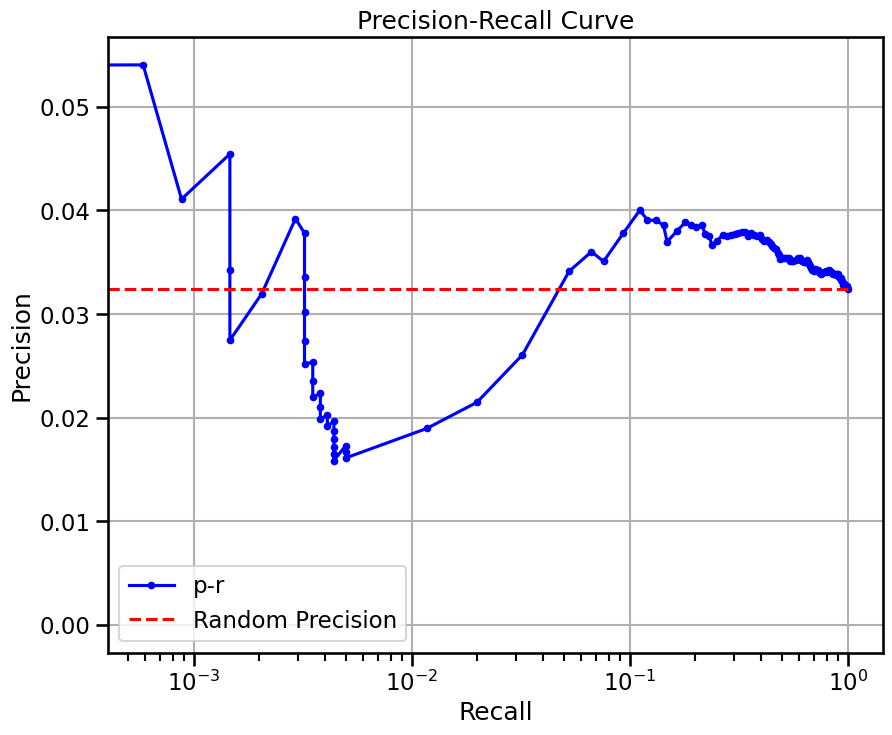

{'precision': 0.03237918250860442,
 'recall': 1.0,
 'rand_precision': 0.032420065314802154,
 'auprc': 0.03523648688593081,
 'ap': 0.03532127706722293,
 'epr': 0.6167043151659773}

In [11]:
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment
Top central genes: []


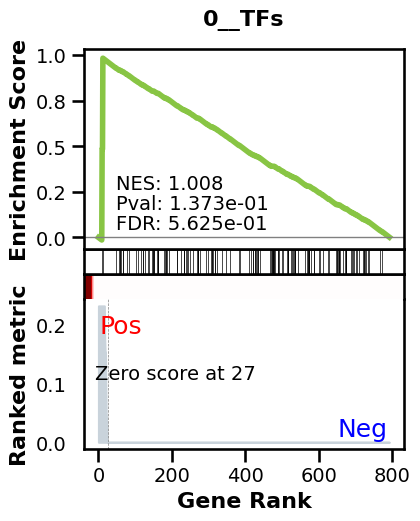

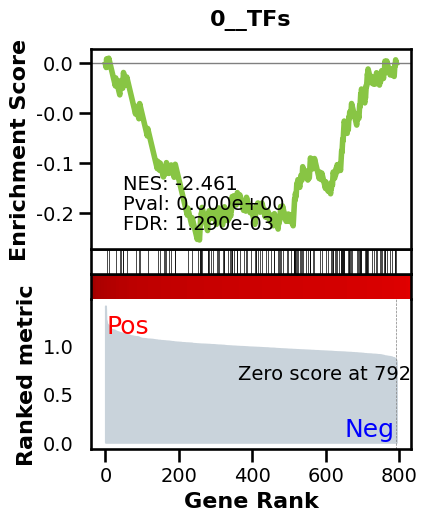

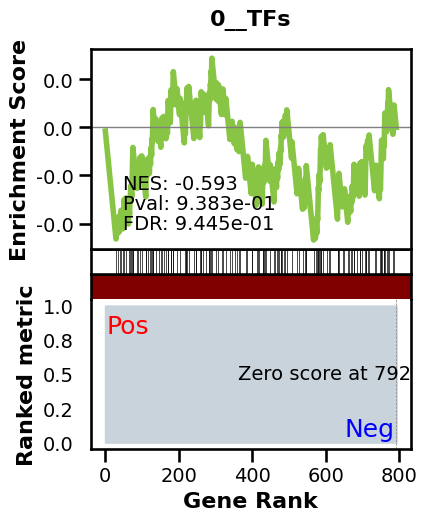

_________________________________________
TF specific enrichment
found some significant results for  10.526315789473685 % TFs

_________________________________________
loading GT,  omnipath
intersection of 649 genes
intersection pct: 0.8184110970996217
precision:  0.024895477456131396 
recall:  1.0 
random precision: 0.024933896402822956


 74%|███████▍  | 95/128 [00:00<00:00, 946.67it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 901.81it/s]

Average Precision (AP):  0.023744032986738273
Area Under Precision-Recall Curve (AUPRC):  0.023718646625575424
EPR: 0.8108490719106958


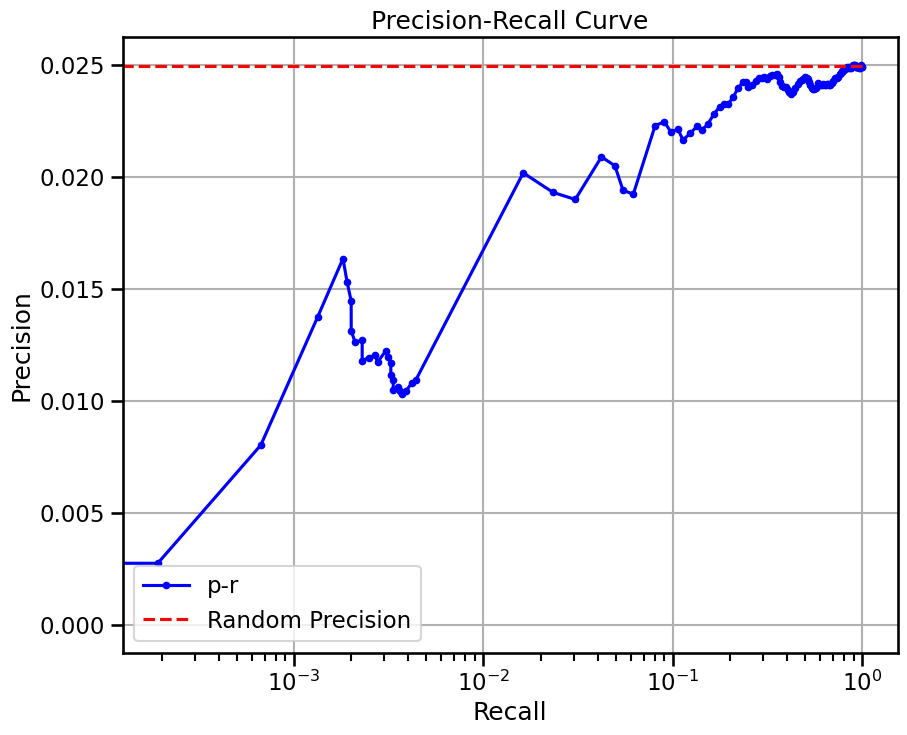

{'TF_enr': True,
 'enriched_terms_Regulators': ['celltype.gmt__Enterocytes',
  'celltype.gmt__Beta cells',
  'celltype.gmt__Foveolar cells',
  'celltype.gmt__Immune system cells',
  'celltype.gmt__Langerhans cells',
  'celltype.gmt__Cholangiocytes'],
 'enriched_terms_Targets': ['celltype.gmt__Langerhans cells',
  'celltype.gmt__ISG expressing immune cells',
  'celltype.gmt__Immune system cells'],
 'significant_enriched_TFtargets': 10.526315789473685,
 'precision': 0.024895477456131396,
 'recall': 1.0,
 'rand_precision': 0.024933896402822956,
 'auprc': 0.023718646625575424,
 'ap': 0.023744032986738273,
 'epr': 0.8108490719106958}

In [12]:
BenGRN(grn).scprint_benchmark()